In [4]:
#!pip install gmusicapi
from gmusicapi import Mobileclient,Webclient,Musicmanager
from gmusicapi.utils import utils
print (utils.log_filepath)

import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import keras as ks
from matplotlib import pyplot as plt
%matplotlib inline

# !pip install --upgrade gensim
import gensim

import sklearn as sk
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.cluster
from sklearn import neural_network
import sklearn.decomposition
import sklearn.mixture

import json
# !pip install tqdm
from tqdm import tqdm_notebook as tqdm
import requests

/Users/aduriseti/Library/Logs/gmusicapi/gmusicapi.log


Using TensorFlow backend.
/Users/aduriseti/anaconda/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
email = 'aduriseti@gmail.com'
pswd = 'ehshpxjlzaaoknix'

api = Mobileclient(debug_logging=False)
api.login(email,pswd,api.FROM_MAC_ADDRESS)

True

In [6]:
# get all songs associated with account
songs = api.get_all_songs()
playlists = api.get_all_playlists()
playlist_content = api.get_all_user_playlist_contents()
# stations = api.get_all_stations()
allsongs_name = 'allsongs'
allsongs_id = ([None]+[p['storeId'] for p in playlists if p['name'] == allsongs_name])[0]
sids = []
sids += [s['id'] for s in songs]
print('PLAYLIST')
for p in tqdm(playlist_content):
    sids += [t['track']['storeId'] if 'track' in t else t['id'] for t in p['tracks']]

PLAYLIST



In [7]:
usids = list(set(sids))
len(sids),len(usids)

(619, 610)

In [8]:
queues_format_filename = 'queues_v0.json'
try:
    with open(queues_format_filename) as queuesfile:
        queues = json.load(queuesfile)
except:
    queues = []
len(queues)

7674

In [9]:
queues_md,queues_id = list(zip(*[list(zip(*q)) for q in queues if q]))

53230

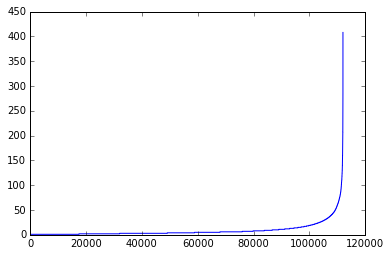

In [10]:
cdict = {}
for q in queues_id:
    for sid in q:
        if sid not in cdict:
            cdict[sid] =0
        cdict[sid] += 1        

plt.plot(sorted(v for k,v in cdict.items()))
sum(1 for sid,c in cdict.items() if c >= 5)

In [11]:
sids = list(set(sid for q in queues_id for sid in q))
sid2md = dict((sid,md) for q in queues for md,sid in q)

genres = set(md[2] for q in queues_md for md in q)
idx2genre = dict(enumerate(genres))
genre2idx = dict((g,i) for i,g in enumerate(genres))

In [12]:
artists = set(md[1] for q in queues_md for md in q)
idx2artist = dict(enumerate(artists))
artist2idx = dict((a,i) for i,a in enumerate(artists))

In [13]:
artcdict = dict((a,0) for a in artists)
for q in queues_md:
    for md in q:
        artcdict[md[1]] += 1

In [231]:
thresh = 100
artists = [a for a,c in artcdict.items() if c > thresh]
idx2artist = dict(enumerate(artists))
artist2idx = dict((a,i) for i,a in enumerate(artists))

In [232]:
len(artists)

1770

In [16]:
%%time
w2vembdim = 64
songid_model = gensim.models.Word2Vec(sentences=queues_id,size=w2vembdim,window=200,min_count=5)
# songid_model = gensim.models.LsiModel(corpus=queues_id,num_topics=200)

CPU times: user 1min 3s, sys: 1.1 s, total: 1min 4s
Wall time: 50.1 s


In [233]:
sids = np.array(list(songid_model.wv.vocab.keys()))
smd = np.array([sid2md[sid] for sid in sids])
sgenre = np.array([md[2] for md in smd])
syear = np.array([md[3] for md in smd])
# sp.spa
sgenre1hot = np.eye(len(genres))[np.array([genre2idx[g] for g in sgenre])]
sartist = np.array([md[1] for md in smd])
data = [1]*(len(sartist))
row = range(len(sartist))
col = [artist2idx[a] if a in artist2idx else len(artists) 
       for a in sartist]
sartist1hot = sp.sparse.csr_matrix((data,(row,col)))
# sartist1hot = np.eye(len(artists))[np.array([artist2idx[a] for a  in sartist])]
svec = np.array([songid_model.wv[sid] for sid in sids])
syear[syear == None] = np.mean(syear[syear!=None])
syear = syear.astype(float)
syear -= np.mean(syear)

In [234]:
sartist1hot = sartist1hot.todense()
sartist1hot.sum(axis=0)

matrix([[    3,    18,    24, ...,    15,    16, 13060]], dtype=int64)

In [211]:
X = ks.Input(shape=svec.shape[1:])

Z1 = ks.layers.Dense(units=100)(X)
A1 = ks.layers.Activation('relu')(Z1)

# Embedding
nnembdim = 32
Z2 = ks.layers.Dense(units=nnembdim)(Z1)
# A2 = ks.layers.Activation('tanh')(Z2)
A2emb = ks.layers.Activation('tanh')(Z2)
A2mu = ks.layers.Dense(units=nnembdim)(A2emb)
A2logvar = ks.layers.Dense(units=nnembdim)(A2emb)
def variation(args):
    mu,logvar = args
    batch,emb = ks.backend.shape(mu)[0],ks.backend.int_shape(mu)[1]
    eps = ks.backend.random_normal(shape=(batch,emb),mean=0,stddev=1)
    return mu + ks.backend.exp(0.5*logvar)*eps
A2 = ks.layers.Lambda(variation)([A2mu,A2logvar])

# GENRE PREDICTION
Z3g = ks.layers.Dense(units=100)(A2)
A3g = ks.layers.Activation('relu')(Z3g)

Z4g = ks.layers.Dense(units=len(genres))(A3g)
Yg = ks.layers.Activation('softmax')(Z4g)

# YEAR PREDICTION
Z3y = ks.layers.Dense(units=100)(A2)
A3y = ks.layers.Activation('relu')(Z3y)

Yy = ks.layers.Dense(units=1)(A3y)
# Yy = ks.layers.Activation('relu')(Z4y)

# ARTIST PREDICTION
Z3a = ks.layers.Dense(units=100)(A2)
A3a = ks.layers.Activation('relu')(Z3a)

Z4a = ks.layers.Dense(units=len(artists)+1)(A3a)
Ya = ks.layers.Activation('softmax')(Z4a)

In [212]:
sartist1hot.shape

(53230, 169)

In [230]:
sartist1hot.sum(axis=0)

matrix([[   40,    30,    53,    69,    61,    55,    60,    64,    41,
            63,    75,    49,    52,    43,    66,    87,    67,    70,
            38,    43,    66,   100,    45,    35,    41,    74,    61,
            93,    68,    85,    59,    66,    18,    44,    40,    83,
           109,   108,    50,    86,    45,    67,    64,    52,    37,
           137,    84,    34,   115,    57,    48,    77,    76,    75,
            38,    55,    43,    34,    46,    55,    43,    66,    48,
            22,    65,    68,    64,    35,    50,    46,    83,    22,
            31,    91,    76,    86,    58,    56,    44,    68,    80,
            58,    73,    93,    36,    52,   104,    65,    47,    66,
            47,    65,    58,    71,    65,    65,    53,    62,    51,
            47,    51,    50,    49,    57,    57,    41,    66,    49,
            49,    48,    36,    61,    64,    64,    54,   108,    56,
            82,    62,    68,    57,    82,   101,   101,    66,

In [213]:
GenreIn = ks.Input(shape=(sgenre1hot.shape[1:]))
YearIn = ks.Input(shape=(1,))
# ArtistIn = ks.Input(shape(sartist1hot.shape[1:]))
genreloss = ks.losses.categorical_crossentropy(GenreIn,Yg)
yearloss = ks.losses.MSE(YearIn,Yy)
kl_loss = -0.5 * ks.backend.mean(
    1 + A2logvar - ks.backend.square(A2mu) - ks.backend.exp(A2logvar))
# artistloss = ks.losses.categorical_crossentropy(ArtistIn,Ya)

trainEmb = ks.models.Model(inputs=[X,GenreIn,YearIn],outputs=[Yg,Yy])
opt = ks.optimizers.Adam(lr=0.01)
trainEmb.add_loss(ks.backend.mean(genreloss + yearloss/100 + kl_loss))
trainEmb.compile(optimizer=opt,metrics=['accuracy'])

In [214]:
# hist = trainEmb.fit(x=[svec,sgenre1hot,syear],y=[sgenre1hot],batch_size=2048,epochs=1)
hist = trainEmb.fit(x=[svec,sgenre1hot,syear],batch_size=2048,epochs=20)

Epoch 1/20
53230/53230 [==============================] - 6s 114us/step - loss: 4.5007
Epoch 2/20
53230/53230 [==============================] - 2s 33us/step - loss: 3.3806
Epoch 3/20
53230/53230 [==============================] - 2s 34us/step - loss: 3.1988
Epoch 4/20
53230/53230 [==============================] - 2s 32us/step - loss: 3.0954
Epoch 5/20
53230/53230 [==============================] - 2s 36us/step - loss: 3.0321
Epoch 6/20
53230/53230 [==============================] - 2s 31us/step - loss: 2.9768
Epoch 7/20
53230/53230 [==============================] - 2s 32us/step - loss: 2.9473
Epoch 8/20
53230/53230 [==============================] - 2s 33us/step - loss: 2.9159
Epoch 9/20
53230/53230 [==============================] - 1s 28us/step - loss: 2.8895
Epoch 10/20
53230/53230 [==============================] - 1s 27us/step - loss: 2.8702
Epoch 11/20
53230/53230 [==============================] - 1s 27us/step - loss: 2.8503
Epoch 12/20
53230/53230 [==========================

In [215]:
predGenre = ks.models.Model(inputs=[X],outputs=[Yg])
predGenre.compile(optimizer=opt,loss=ks.losses.categorical_crossentropy,metrics=['accuracy'])
print(predGenre.evaluate(x=[svec],y=[sgenre1hot],batch_size=2048))
predYear = ks.models.Model(inputs=[X],outputs=[Yy])
predYear.compile(optimizer=opt,loss=ks.losses.MSE)
print(predYear.evaluate(x=[svec],y=[syear],batch_size=2048))

53230/53230 [==============================] - 1s 25us/step
[1.6228976292469528, 0.5499718196428339]
53230/53230 [==============================] - 1s 21us/step
87.13742751630876


In [216]:
# trainEmba = ks.models.Model(inputs=[X],outputs=[Ya])
# opt = ks.optimizers.Adam(lr=0.01)
# loss = ks.losses.categorical_crossentropy
# trainEmba.compile(optimizer=opt,loss=loss,metrics=['accuracy'])
# def batchGen(X,y,batch_size):
#     n_batches = X.shape[0] // batch_size
#     randidx = list(range(X.shape[0]))
#     while True:
#         np.random.shuffle(randidx)
#         for i in range(n_batches):
#             batchidx = randidx[i*batch_size:(i+1)*batch_size]
#             Xb = X[batchidx,:]
#             yb = y[batchidx,:].toarray()
#             yield(Xb,yb)

In [217]:
# getEmb = ks.models.Model(inputs=[X],outputs=[A2])
getEmb = ks.models.Model(inputs=[X],outputs=[A2emb])
nnemb = getEmb.predict(x=[svec])
nnemb_wv = dict(zip(sids,nnemb))

In [218]:
# idx2sid = dict(enumerate([sid for sid in sids if sid in songid_model.wv]))
# sid2idx = dict((sid,i) for i,sid in idx2sid.items())
idx2sid = dict(enumerate([sid for sid in sids if sid in nnemb_wv]))
sid2idx = dict((sid,i) for i,sid in idx2sid.items())

In [219]:
# msids = [sid for sid in usids if sid in songid_model.wv]
# X = np.array([songid_model.wv[sid] for sid in msids])
# Xmd = np.array([sid2md[sid] for sid in msids])
msids = [sid for sid in usids if sid in nnemb_wv]
Xvec = np.array([nnemb_wv[sid] for sid in msids])
Xmd = np.array([sid2md[sid] for sid in msids])

In [220]:
Xvec.shape

(539, 32)

In [221]:
if Xvec.shape[1] > 2:
    X2d = sklearn.decomposition.PCA(n_components=2).fit_transform(Xvec)
else:
    X2d = Xvec

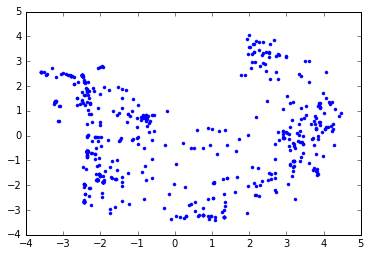

In [222]:
plt.plot(X2d[:,0],X2d[:,1],'.')

In [223]:
n_clusters = len(msids)//20
n_clusters

26

In [224]:
# clst = sklearn.cluster.KMeans(n_clusters=n_clusters) # Good
# clst = sklearn.cluster.AffinityPropagation() # OK
clst = sklearn.cluster.Birch(n_clusters=n_clusters) # Great
# clst = sklearn.cluster.DBSCAN() # didn't get all but Good
# clst = sklearn.mixture.GaussianMixture(n_components=n_clusters) # ok
# clst = sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters) # Great
try:
    labels = clst.fit_predict(Xvec)
except:
    clst.fit(X)
    labels = clst.predict(Xvec)

/Users/aduriseti/anaconda/lib/python3.5/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


In [225]:
clusters = [[str(md) for md,j in zip(Xmd,labels) if j == i] for i in range(max(labels))]

In [226]:
sum(len(c) for c in clusters),Xmd.shape

(521, (539, 4))

In [227]:
print(sorted(len(cluster) for cluster in clusters))

[5, 6, 8, 9, 9, 10, 11, 11, 12, 12, 13, 15, 15, 16, 16, 17, 18, 23, 24, 31, 32, 40, 52, 54, 62]


In [228]:
for i,cluster in sorted(enumerate(clusters),key=lambda tup: -len(tup[1])):
    print(i)
    print(len(cluster))
    print("\n".join(cluster))
    print()

5
62
['Runaway' 'Kanye West' 'Hip-Hop Hitmakers' 2010]
['Baby Boy' 'Childish Gambino' 'R&B/Soul' 2016]
['REVOFEV' 'Kid Cudi' 'Hip-Hop/Rap' 2010]
['Superstar (feat. Matthew Santos)' 'Lupe Fiasco' 'Hip-Hop/Rap' 2007]
['3005' 'Childish Gambino' 'Hip-Hop/Rap' 2013]
["Daydreamin' (feat. Jill Scott)" 'Lupe Fiasco' 'R&B/Soul' 2006]
['King Kunta' 'Kendrick Lamar' 'Hip-Hop/Rap' 2015]
['Run It' 'Logic' 'Hip-Hop/Rap' 2015]
['I Wish' 'Skee-Lo' 'Hip-Hop/Rap' 1995]
['These Worries (feat. Mary J. Blige)' 'Kid Cudi' 'Hip-Hop/Rap' 2010]
['Lower Eastside' 'Delinquent Habits' 'Latin Rap/Hip-Hop en Español' 1996]
['Backseat Freestyle' 'Kendrick Lamar' 'Hip-Hop/Rap' 2012]
['It Could Be Round Two' 'Delinquent Habits' 'West Coast Hip-Hop' 2017]
['Flashing Lights' 'Kanye West' 'Hip-Hop Hitmakers' 2007]
['Mind Playing Tricks on Me' 'Geto Boys' 'Hip-Hop/Rap' 1991]
['Up Up & Away' 'Kid Cudi' 'Hip-Hop/Rap' 2009]
['Little Wing' 'The Jimi Hendrix Experience' 'Classic Rock' 1967]
['Make Her Say' 'Kid Cudi' 'Hip-Hop/

In [ ]:
if all_song
    api.delete_playlist(allsongs_id)
except:
    pass
allsongs_id_new = api.create_playlist(allsongs_name)
api.add_songs_to_playlist(allsongs_id_new,list(set(ids)))